## Analyzing YouTube Channel Data with Linear Regression

The dataset [Found on Kaggle](https://www.kaggle.com/mdhrumil/top-5000-youtube-channels-data-from-socialblade) contains YouTube channel information regarding viewership. Using this data and linear regression, I will attempt to build a model to predict the number of subscribers of a channel based on all other data. The original dataset came in this CSV format:

    Rank, Grade, Channel Name, Video Uploads, Subscribers, Video Views
    
In order to format this data in a way that is more easily fit into a linear regression model, I removed the useless name column, and reordered the columns like so:

    Rank, Grade, Video Uploads, Video Views, Subscribers
    
Additionally, because the "Grade" column previously contained a value like "A++", or "B+", the value was replaced with an integer value on the scale of 1 to 5, as there were only 5 different grades assigned. The ruby script which follows was the script used to ingest and modify the CSV data. Some entries in the original dataset were missing certain values and replaced with `--`, so those data points were omitted from the resulting CSV.

~~~~ruby
#!/usr/bin/ruby

require 'csv'

data = CSV.read('data.csv')
headers = data.shift

grade_map = {
	'A++' => 5,
	'A+' => 4,
	'A' => 3,
	'A-' => 2,
	'B+' => 1
}

CSV.open('modified_data.csv', 'wb') do |csv|
	csv << ['Rank', 'Socialblade Grade', 'Number of Uploads', 'Video Views', 'Subscribers']
	data.each do |entry|
		next if entry[0].empty? or entry.join.include?('--')
		csv << [entry[0].gsub(/\D/, ''), grade_map[entry[1].strip], entry[3], entry[5], entry[4]]
	end
end
~~~~

Coefficients: 
 [-2.12550842e+02 -2.41329869e+04 -1.55060352e+01  1.49052922e-03]
Intercept: 1553929.0321279648
Training Loss Function: 3417941957746.648
Test Lost Function: 3279336873694.353


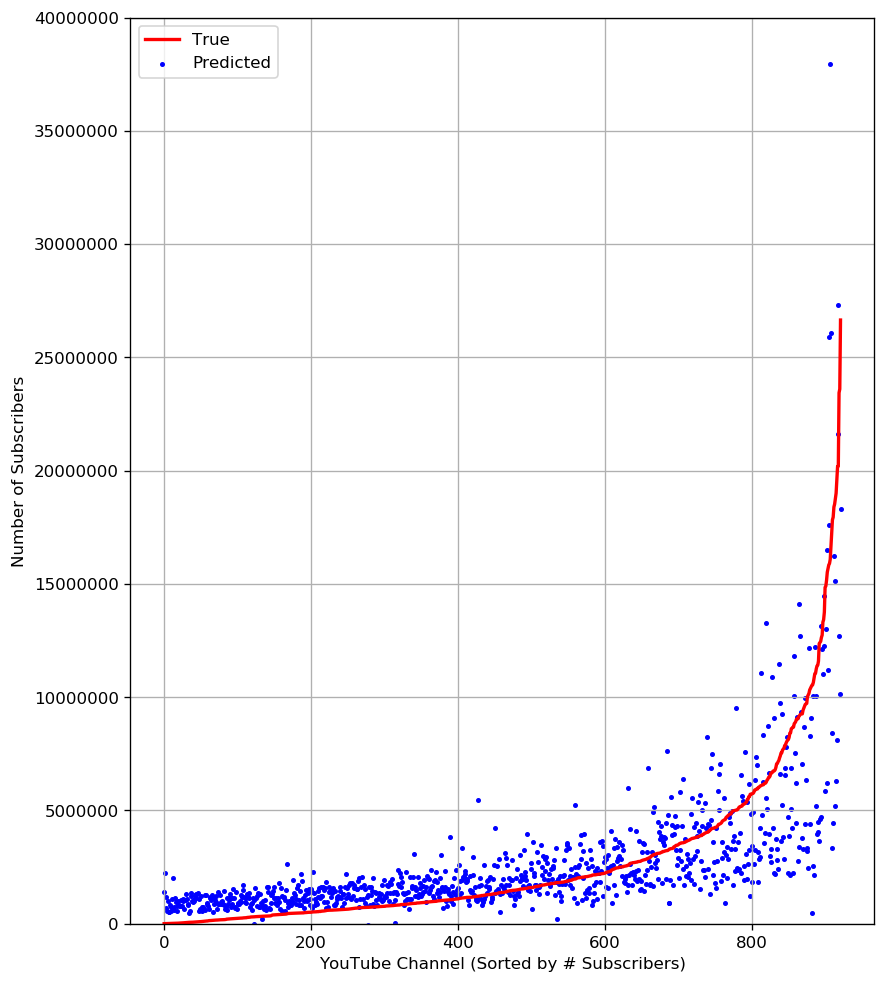

In [34]:
# The modules we're going to use
from __future__ import print_function
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from scipy import linalg
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

# When you execute a code to plot with a simple SHIFT-ENTER, the plot will be shown directly under the code cell
%matplotlib inline

# Load data from CSV file
data_and_target = np.loadtxt('./modified_data.csv', delimiter=',', skiprows=1)
data = data_and_target[:, :-1]
target = data_and_target[:, -1]

# Split the data into two parts: training data and testing data
train_x, test_x, train_y, test_y = train_test_split(data,(target[:, np.newaxis]), test_size=0.2, random_state=42)

# Task 1-1: use linear regression in sklearn
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
pred_y = regr.predict(test_x)

# Task 1-2: show intercept and coefficents
print('Coefficients: \n', regr.coef_[0])
print('Intercept:', regr.intercept_[0])

# Task 1-3: show errors on training dataset and testing dataset
sum = 0
for i in range(1, train_y.size):
    t = train_y[i][0]
    num_features = train_x[0].size
    y = 0
    for j in range(0, num_features):
        if j == 0:
            y += 1
        else:
            y += regr.coef_[0][j] * train_x[i][j]
    sum += (t - y) ** 2
    
sum *= 1 / (2 * train_y.size)
print('Training Loss Function:', sum)

sum = 0
for i in range(1, test_y.size):
    t = test_y[i][0]
    num_features = test_x[0].size
    y = 0
    for j in range(0, num_features):
        if j == 0:
            y += 1
        else:
            y += regr.coef_[0][j] * test_x[i][j]
    sum += (t - y) ** 2
    
sum *= 1 / (2 * test_y.size)
print('Test Lost Function:', sum)

# Task 1-4: show plot a figure to show your predictions and real prices on the testing dataset

# This will sort the test results based on price, ascending, and mirror the exact sort to the
# predicted set. This way we don't actually sort the predicted data set, just arrange it so the
# test -> predicted pairs stay as the same pairs when we sort the test list.
true_plot_data, pred_plot_data = zip(*sorted(zip(test_y.flatten(), pred_y.flatten())))
plt.figure(figsize=(8, 10), dpi=120)
plt.grid(True)
plt.scatter(np.arange(0, test_y.size), pred_plot_data, color='blue', s=4, label='Predicted')
plt.plot(np.arange(0, test_y.size), true_plot_data, color='red', linewidth=2, label='True')
plt.ticklabel_format(useOffset=False, style='plain') # Don't show exponential notation on y-axis
plt.ylim([0, 40_000_000])
plt.xlabel('YouTube Channel (Sorted by # Subscribers)')
plt.ylabel('Number of Subscribers')
plt.legend()
plt.show()